In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import pickle

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

Fly flipped over
Fly flipped over
Fly flipped over
Fly flipped over
Fly flipped over
Error loading file: datapts_gainslope/seed_0/gain_35.0/slope_70.pkl
Fly flipped over
Error loading file: datapts_gainslope/seed_0/gain_60.0/slope_115.pkl
Fly flipped over
Fly flipped over
Error loading file: datapts_gainslope/seed_1/gain_40.0/slope_25.pkl
Fly flipped over
Fly flipped over
Fly flipped over
Fly flipped over
[30.0, 25.0, 50.0, 35.0, 45.0, 5.0, 20.0, 40.0, 10.0, 60.0, 55.0, 0.0, 15.0, 30.0, 25.0, 50.0, 35.0, 45.0, 5.0, 20.0, 40.0, 10.0, 60.0, 55.0, 0.0, 15.0, 30.0, 25.0, 50.0, 35.0, 45.0, 5.0, 20.0, 40.0, 10.0, 60.0, 55.0, 0.0, 15.0, 30.0, 25.0, 50.0, 35.0, 45.0, 5.0, 20.0, 40.0, 10.0, 60.0, 55.0, 0.0, 15.0, 30.0, 25.0, 50.0, 35.0, 45.0, 5.0, 20.0, 40.0, 10.0, 60.0, 55.0, 0.0, 15.0] [100.0, 95.0, 90.0, 60.0, 100.0, 20.0, 90.0, 105.0, 35.0, 105.0, 65.0, 5.0, 70.0, 85.0, 85.0, 105.0, 95.0, 100.0, 15.0, 75.0, 80.0, 35.0, 85.0, 100.0, 5.0, 60.0, 95.0, 90.0, 90.0, 90.0, 90.0, 20.0, 95.0, 95.0, 

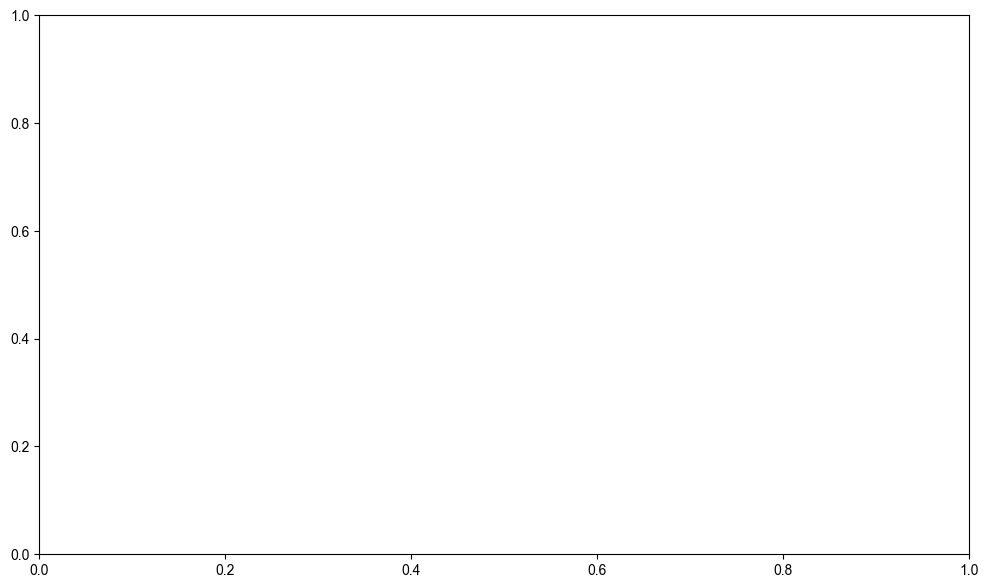

In [3]:
base_data_path = Path("datapts_gainslope")
gains = []
seeds = []
critical_slopes = []
reached_end_all = []
reached_end_critical = []

is_critical = True

x_pos_thr = -6 #two body lengths

# Go through all pkl files
gain_folders = base_data_path.glob("seed_*/gain_*")
for gain_folder in gain_folders:
    gains.append(float(gain_folder.name.split("_")[1]))
    seeds.append(int(gain_folder.parent.name.split("_")[1]))
    metadata_file = gain_folder / "slope_metadata.pkl"
    with open(metadata_file, "rb") as f:
        metadata = pickle.load(f)
    slope_files = sorted(gain_folder.glob("slope_[0123456789.]*.pkl"), key=lambda x: float(x.name.split("_")[1].split(".")[0]))
    for slope_file in slope_files:
        with open(slope_file, "rb") as f:
            try:
                obs_list = pickle.load(f)
            except EOFError:
                print("Error loading file:", slope_file)
                reached_end_all.append(False)
                continue
        # Check if the end was reached
        is_complete = len(obs_list) == np.ceil((metadata["run_time"]+metadata["stabilisation_dur"])/metadata["timestep"])
        reached_end_all.append(is_complete)

        if len(gains) == len(critical_slopes):
            #print(gain_folder.name, slope_file.name, "already processed")
            continue
        
        # When gravity is reversed, xpos is not zeros
        # check wether the x pos is threshold away from the position it was when gravity was reversed

        # In case something went wrong, check if the fly was flipped (maybe with low slopes, the fly flips over but does not go reverse x due to friciton)

        reverse_id = int(np.ceil(metadata["slope_reversal_time"]/metadata["timestep"]))

        fly_xvel = np.array([obs["fly"][1, 2] for obs in obs_list])
        fly_xpos = np.array([obs["fly"][0, 0] for obs in obs_list])
        fly_xpos_treverse_is_origin = fly_xpos[reverse_id:] - fly_xpos[reverse_id]
        is_critical = np.any(fly_xpos_treverse_is_origin < x_pos_thr)
        if not is_critical:
            # check wether the fly just flipped over
            fly_ang = np.array([obs["fly"][2][1:] for obs in obs_list])
            is_critical = np.any(np.abs(fly_ang) > np.pi/2)
            if is_critical:
                print("Fly flipped over")
        if is_critical:
            critical_slopes.append(float(slope_file.name.split("_")[1].split(".")[0]))
            reached_end_critical.append(is_complete)
            # DO NOT BREAK JUST TO CHECK IF SOME SIMULATION DID NOT REACH THE END

print(gains, critical_slopes, reached_end_critical)

fig, ax = plt.subplots(figsize=(12, 7))

ids_reached_end = np.where(reached_end_critical)[0]
ids_did_not_reach_end = np.where(np.logical_not(reached_end_critical))[0]

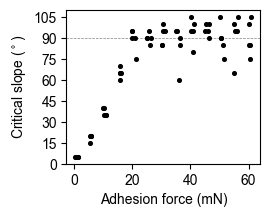

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2))
scatter = ax.scatter(
    np.array(gains)+np.random.rand(len(gains))*1.5,
    critical_slopes,
    s=7,
    color="black"
)
ax.set_xlabel("Adhesion force (mN)")
ax.set_ylabel("Critical slope ($^\circ$)")
ax.axhline(90, color="gray", linestyle="--", linewidth=0.5, zorder=-1)
ax.set_yticks([0, 15, 30, 45, 60, 75, 90, 105])
fig.savefig("outputs/critical_slope.pdf", transparent=True)